## Семинар 9: "LSTM"

ФИО: Дорожинский Владислав Игоревич

In [2]:
import numpy as np
import time
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.optim.lr_scheduler import StepLR
import pandas
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        h_0, c_0 = hidden
        bs = h_0.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        if (next(self.parameters()).is_cuda):
            out = out.cuda()
            
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h_0, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c_0 = f_1 * c_0 + i_1 * g_1
            h_0 = o_1 * torch.tanh(c_0)
            out[i] = h_0
        return out, (h_0, c_0)
            
        

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM сделать решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

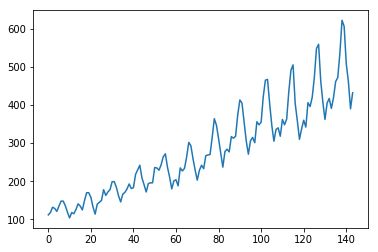

In [4]:
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [5]:
# plt.plot([(dataset[i, 0]) / (dataset[i+1, 0] + 2e-2) for i in range(0, len(dataset) - 1)]);

In [6]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [8]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [9]:
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
class PassengerDataset(Dataset):
    def __init__(self, trainX, trainY):
        self.trainX = trainX
        self.trainY = trainY

    def __len__(self):
        return len(self.trainY)

    def __getitem__(self, idx):
        return self.trainX[idx], self.trainY[idx]
    
train_dataset = PassengerDataset(trainX, trainY)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)

test_dataset = PassengerDataset(testX, testY)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# torch.nn.LSTM

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)

        self.hidden2out = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(1)
        batch_size = inp.size(0)
        hidden = (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)).cuda(),
                  Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)).cuda())
        #inp = PackedSequence(inp, inp.shape[0])
        inp = pack_sequence(inp)
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out, _ = pad_packed_sequence(lstm_out)
        lstm_out = lstm_out[-1]
        
        out = self.hidden2out(lstm_out.view(batch_size, self.hidden_dim))
        return out

In [15]:
def generate(model, n, inputs, batch_first=True):
    result = np.zeros(n + len(inputs))
    result[:len(inputs)] = inputs
    inp = 0
    for i in range(n):
        if batch_first:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(1, len(inputs), 1).cuda()
        else:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(len(inputs), 1, 1).cuda()
        res = lstm(inp)
        result[i + len(inputs)] = res[-1].cpu().data.numpy()
    return result

In [16]:
lstm = LSTMModel(8, 1).cuda()

In [17]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, 1)

In [25]:
n_epochs = 1500
loss_f = nn.MSELoss()
for reduce in range(3):
    for epoch in range(n_epochs):
        losses = []
        for X, Y in train_dataloader:
            lstm.zero_grad()
            X = Variable(torch.FloatTensor(X)).view(-1, look_back, 1).cuda()
            Y = Variable(torch.FloatTensor(Y)).view(-1, 1).cuda()

            p = lstm(X)
            
            loss = loss_f(p, Y)
            losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
        if epoch % 200 == 0:
            print('[{}]: {}'.format(epoch, np.mean(losses)))
    scheduler.step()

[0]: 3.168739658576669e-05
[200]: 1.1107315003755502e-05
[400]: 1.3499392935045762e-05
[600]: 1.6657943433529e-05


KeyboardInterrupt: 

In [75]:
seq = train[:,0]
start = 0
plength = 90
blength = 20
base =  seq[start:start+blength]
predicted = generate(lstm, plength, base)
actual = seq[start:start+plength+blength]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)

TypeError: 'long' object has no attribute '__getitem__'

# custom LSTM

In [105]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = LSTM(1, hidden_dim)

        self.hidden2out = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(0)
        batch_size = inp.size(1)
        hidden = (Variable(torch.zeros(batch_size, self.hidden_dim)).cuda(),
                  Variable(torch.zeros(batch_size, self.hidden_dim)).cuda())
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out = lstm_out[-1]
        
        out = self.hidden2out(lstm_out.view(batch_size, self.hidden_dim))
        return out

In [134]:
lstm = LSTMModel(8).cuda()

In [135]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-1)
scheduler = StepLR(optimizer, 1)

In [136]:
n_epochs = 1200
loss_f = nn.MSELoss()
start = time.time()
for reduce in range(3):
    for epoch in range(n_epochs):
        losses = []
        for X, Y in train_dataloader:
            lstm.zero_grad()
            X = Variable(X.permute(1,0).unsqueeze(-1)).cuda()
            Y = Variable(Y).cuda()
            p = lstm(X).squeeze()
            
            loss = loss_f(p, Y)
            losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
        if epoch % 200 == 0:
            elapsed = time.time() - start
            print('[{}]: {:.3e}, elapsed: {:.2f} s.'.format(epoch, np.mean(losses), elapsed))
            start = time.time()
    scheduler.step()

[0]: 1.881e-02, elapsed: 0.02 s.
[200]: 1.940e-03, elapsed: 3.80 s.
[400]: 1.500e-03, elapsed: 3.81 s.
[600]: 1.200e-03, elapsed: 3.77 s.
[800]: 1.700e-03, elapsed: 4.03 s.
[1000]: 1.462e-03, elapsed: 4.01 s.
[0]: 3.884e-04, elapsed: 3.90 s.
[200]: 2.355e-04, elapsed: 3.71 s.
[400]: 1.175e-04, elapsed: 3.78 s.
[600]: 6.323e-05, elapsed: 3.63 s.
[800]: 9.213e-05, elapsed: 3.74 s.
[1000]: 9.761e-05, elapsed: 3.90 s.
[0]: 2.501e-04, elapsed: 3.76 s.
[200]: 1.076e-05, elapsed: 3.64 s.
[400]: 9.993e-06, elapsed: 3.65 s.
[600]: 7.026e-06, elapsed: 3.78 s.
[800]: 6.153e-06, elapsed: 3.84 s.
[1000]: 6.836e-06, elapsed: 3.63 s.


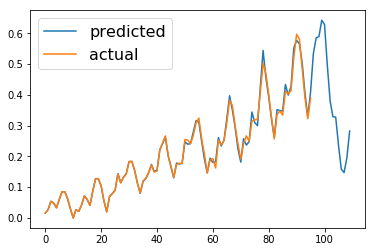

In [137]:
seq = train.reshape(-1)
start = 0
plength = 90
blength = 20
base =  seq[start:start+blength]
predicted = generate(lstm, plength, base, batch_first=0)
actual = seq[start:start+plength+blength]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16);

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: